In [33]:
# Calculer le taux de tir moyen par heure par emplacement pour une saison donnée, puis
# visualiser sur une image de demi-glace de hockey
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

In [34]:
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

from pipeline.download_data import extract_game_ids
game_ids = extract_game_ids("MTL", 2024)

In [35]:
# Charger l'image de la demi-glace
half_rink_image_path = Path("../assets/half_rink.png")
half_rink_image = mpimg.imread(half_rink_image_path)

In [ ]:
# Récupérer les données de tirs pour l'équipe MTL en 2024-2025 
shots_data_path = Path("../data/2024_2025/shots_data_MTL_2024_2025.csv")
shots_df = pd.read_csv(shots_data_path)

In [37]:
# Transformation des coordonnées pour centrer sur la demi-glace 
def transform_coordinates(shots_df):

    df = shots_df.copy()

    x0 = df["x_coord"].to_numpy(dtype=float)
    y0 = df["y_coord"].to_numpy(dtype=float)

    mask_right = x0 > 0 

    df["x_coord"] = np.where(mask_right, -x0, x0)
    df["y_coord"] = np.where(mask_right, -y0, y0)

    x_temp = df["x_coord"].copy()
    df["x_coord"] = -df["y_coord"]
    df["y_coord"] = x_temp

    df["y_coord"] = df["y_coord"] - 2.5  # ajuster verticalement pour centrer sur le but

    df["x_coord"] = df["x_coord"].clip(-42.5, 42.5)
    df["y_coord"] = df["y_coord"].clip(-100, 0)

    return df



In [38]:
# Utiliser les informations de time-in-period pour estimer le temps total joué à forces égales
# par emplacement pour MTL et le reste de la ligue

def compute_5v5_time_seconds(
    df: pd.DataFrame,
    *,
    game_col: str = "game_id",
    period_col: str = "period",
    time_col: str = "period_time",     # format "MM:SS" (temps restant)
    strength_col: str = "strength",
    strength_5v5_value: str = "even-strength",
    period_length_seconds: int = 20 * 60, # 20 min pour périodes 1-3
    period_length_overrides: dict[int, int] | None = None,  # ex: {4: 5*60}
    assume_sorted: bool = False,
) -> int:
    """
    Calcule le temps total (en secondes) joué à 5v5 en additionnant le temps
    entre événements consécutifs lorsque l'événement courant est à 5v5.

    Logique:
    - Si l'événement i est 5v5, on ajoute (t_{i+1} - t_i) au temps 5v5,
      même si l'événement i+1 est une pénalité (la bascule de force se fait au temps du prochain event).
    - Si l'événement i n'est pas 5v5, on n'ajoute rien.
    - On travaille séparément par (game_id, period).
    - On ajoute aussi le temps de la dernière observation jusqu'à la fin de la période
      si le dernier event de la période est 5v5.

    Retourne: total en secondes.
    """

    def mmss_to_seconds_remaining(s: str) -> int:
        # s = "MM:SS" temps restant
        m, sec = s.split(":")
        return int(m) * 60 + int(sec)

    if period_length_overrides is None:
        period_length_overrides = {}

    work = df.copy()

    # Nettoyage minimal
    work = work.dropna(subset=[game_col, period_col, time_col, strength_col])

    # Convertir time_in_period (restant) -> elapsed seconds dans la période (croissant)
    work["_sec_remaining"] = work[time_col].astype(str).apply(mmss_to_seconds_remaining)

    # Longueur de période (pour reg vs OT si tu veux)
    def period_len(p: int) -> int:
        return period_length_overrides.get(int(p), period_length_seconds)

    work["_period_len"] = work[period_col].astype(int).apply(period_len)

    # elapsed = période_len - remaining
    work["_sec_elapsed"] = work["_period_len"] - work["_sec_remaining"]

    # S'assurer d'un ordre temporel correct
    if not assume_sorted:
        work = work.sort_values([game_col, period_col, "_sec_elapsed"], kind="mergesort")

    total_5v5 = 0

    # Parcours par match + période
    for (gid, per), g in work.groupby([game_col, period_col], sort=False):
        g = g.reset_index(drop=True)

        # deltas vers l'event suivant
        next_elapsed = g["_sec_elapsed"].shift(-1)
        delta = (next_elapsed - g["_sec_elapsed"]).fillna(0)

        # éviter deltas négatifs si données bizarres
        delta = delta.clip(lower=0)

        # Ajouter delta si l'event courant est 5v5
        is_5v5_now = g[strength_col].astype(str).eq(strength_5v5_value)
        total_5v5 += int(delta[is_5v5_now].sum())

        # Ajouter le temps restant jusqu'à la fin de période si le dernier event est 5v5
        if len(g) > 0 and bool(is_5v5_now.iloc[-1]):
            period_len_sec = int(g["_period_len"].iloc[-1])
            end_delta = period_len_sec - int(g["_sec_elapsed"].iloc[-1])
            if end_delta > 0:
                total_5v5 += end_delta

    return total_5v5

In [39]:
# Visualisation des tirs bloqués par emplacement pour MTL par rapport au reste de la ligue
from nhlpy import NHLClient

# Combiner les données de tirs bloqués de toutes les équipes pour la saison 2024-2025, sauf MTL

# Extraire les abréviations des équipes 
client = NHLClient()
teams = client.teams.teams()
teams_abbr = [team['abbr'] for team in teams]

time_even_strength_seconds = []

# Initialiser un dataframe pandas vide pour les tirs non bloqués des autres équipes 
other_teams_unblocked_shots_df = pd.DataFrame()

unblocked_shot_types = ["shot-on-goal", "missed-shot", "goal"]

for team in teams_abbr:
    data_path = Path(f"../data/shots_data_{team}_2024_2025.csv")
    team_shots_df = pd.read_csv(data_path)

    team_unblocked_shots_df = team_shots_df[team_shots_df["shot_type_desc"].isin(unblocked_shot_types)].copy()
    time_even_strength_seconds.append(compute_5v5_time_seconds(team_unblocked_shots_df))
    team_unblocked_shots_df = team_unblocked_shots_df[team_unblocked_shots_df["strength"] == "even-strength"].copy()
    team_unblocked_shots_df = team_unblocked_shots_df[team_unblocked_shots_df["team_abbr"] == team].copy()
    team_unblocked_shots_df = transform_coordinates(team_unblocked_shots_df)

    # Ajouter les données de l'équipe au dataframe global, sauf pour MTL
    if team != "MTL":
        other_teams_unblocked_shots_df = pd.concat([other_teams_unblocked_shots_df, team_unblocked_shots_df], ignore_index=True)
    else:
        MTL_unblocked_shots_df_path = Path(f"../data/advanced/unblocked_shots_data_{team}_2024_2025_unblocked.csv")
        team_unblocked_shots_df.to_csv(MTL_unblocked_shots_df_path, index=False)

# Enregistrer les données combinées dans un fichier csv
other_teams_unblocked_shots_data_path = Path("../data/advanced/other_teams_unblocked_shots_2024_2025.csv")
other_teams_unblocked_shots_df.to_csv(other_teams_unblocked_shots_data_path, index=False)

print(time_even_strength_seconds)
print(len(time_even_strength_seconds))



[250030, 269304, 243823, 231334, 275810, 249998, 240221, 274058, 227668, 298899, 224139, 229960, 232800, 265556, 228386, 255832, 290323, 226601, 232436, 241632, 229790, 227378, 233035, 248229, 243980, 227263, 231225, 228723, 255055, 237384, 271379, 225753]
32


In [40]:
# Calculer le nombre de tirs non bloqués par minute de jeu à forces égales pour MTL et le reste de la ligue

# Charger les données de tirs non bloqués pour MTL et le reste de la ligue
MTL_unblocked_shots_df_path = Path(f"../data/advanced/unblocked_shots_data_MTL_2024_2025_unblocked.csv")
MTL_unblocked_shots_df = pd.read_csv(MTL_unblocked_shots_df_path)

other_teams_unblocked_shots_data_path = Path("../data/advanced/other_teams_unblocked_shots_2024_2025.csv")
other_teams_unblocked_shots_df = pd.read_csv(other_teams_unblocked_shots_data_path)

mtl_idx = teams_abbr.index("MTL")

# Temps 5v5 en secondes
mtl_5v5_seconds = time_even_strength_seconds[mtl_idx]
league_5v5_seconds = sum(time_even_strength_seconds)

other_teams_5v5_seconds = league_5v5_seconds - mtl_5v5_seconds

# Shots / 60
MTL_unblocked_shots_per_60 = len(MTL_unblocked_shots_df) / mtl_5v5_seconds * 3600
other_teams_unblocked_shots_per_60 = len(other_teams_unblocked_shots_df) / other_teams_5v5_seconds * 3600

print(f"MTL unblocked shots / 60 at even strength: {MTL_unblocked_shots_per_60:.2f}")
print(f"Other teams unblocked shots / 60 at even strength: {other_teams_unblocked_shots_per_60:.2f}")


MTL unblocked shots / 60 at even strength: 41.33
Other teams unblocked shots / 60 at even strength: 43.79


In [41]:
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter
import numpy as np

def kde_surface_shots_per_60(
    df,
    seconds_5v5,
    *,
    x_col="x_coord",
    y_col="y_coord",
    x_range=(-42.5, 42.5),
    y_range=(-100, 0),
    grid_size=180,
    bw=0.20,
    max_samples=8000, 
    seed=0,
):
    x = df[x_col].to_numpy(dtype=float)
    y = df[y_col].to_numpy(dtype=float)

    n = x.size
    if max_samples is not None and n > max_samples:
        rng = np.random.default_rng(seed)
        idx = rng.choice(n, size=max_samples, replace=False)
        x = x[idx]
        y = y[idx]

    xg = np.linspace(x_range[0], x_range[1], grid_size)
    yg = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(xg, yg)

    kde = gaussian_kde(np.vstack([x, y]), bw_method=bw)
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(grid_size, grid_size)

    Z_60 = Z * (3600.0 / float(seconds_5v5))
    return X, Y, Z_60

Y_MIN, Y_MAX = -86.5, -27.5
X_MIN, X_MAX = -42.5, 42.5

MTL_unblocked_shots_df = MTL_unblocked_shots_df[
    (MTL_unblocked_shots_df["x_coord"].between(X_MIN, X_MAX)) &
    (MTL_unblocked_shots_df["y_coord"].between(Y_MIN, Y_MAX))
]

other_teams_unblocked_shots_df = other_teams_unblocked_shots_df[
    (other_teams_unblocked_shots_df["x_coord"].between(X_MIN, X_MAX)) &
    (other_teams_unblocked_shots_df["y_coord"].between(Y_MIN, Y_MAX))
]

print(MTL_unblocked_shots_df[["x_coord", "y_coord"]].describe())

# MTL 
X_mtl, Y_mtl, Z_mtl_60 = kde_surface_shots_per_60(
    MTL_unblocked_shots_df,
    mtl_5v5_seconds,
    grid_size=120,
    bw=0.20,
    max_samples=None # utiliser toutes les données de MTL
)

# Ligue (moyenne par équipe) 
Z_lg_accum = None
n_teams = 0

for i, team in enumerate(teams_abbr):
    if team == "MTL":
        continue

    df_t = other_teams_unblocked_shots_df[
        other_teams_unblocked_shots_df["team_abbr"] == team
    ]
    if df_t.empty:
        continue

    seconds_t = time_even_strength_seconds[i]

    _, _, Z_t_60 = kde_surface_shots_per_60(
        df_t,
        seconds_t,
        grid_size=120,
        bw=0.20,
        max_samples=8000, 
        seed=0
    )

    Z_lg_accum = Z_t_60 if Z_lg_accum is None else (Z_lg_accum + Z_t_60)
    n_teams += 1

Z_lg_60 = Z_lg_accum / n_teams

# Smoothing 
Z_mtl_60 = gaussian_filter(Z_mtl_60, sigma=1.0)
Z_lg_60  = gaussian_filter(Z_lg_60,  sigma=1.0)

Z_diff = Z_mtl_60 - Z_lg_60


print("Z_diff min/max/mean:", Z_diff.min(), Z_diff.max(), Z_diff.mean())




           x_coord      y_coord
count  2494.000000  2494.000000
mean      0.951885   -62.067763
std      20.074213    17.234142
min     -41.000000   -86.500000
25%     -13.000000   -77.500000
50%      -0.000000   -64.500000
75%      16.000000   -48.500000
max      42.000000   -27.500000
Z_diff min/max/mean: -8.162901943211605e-07 1.5693558039148185e-06 3.4749445920356264e-08


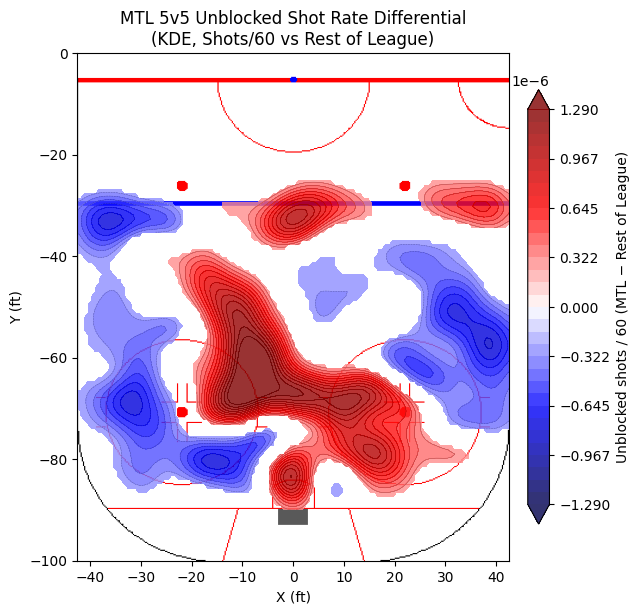

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Visualisation : carte différentielle (MTL - ligue) 

x_range = (-42.5, 42.5)
y_range = (-100, 0)

fig, ax = plt.subplots(figsize=(6.5, 9))

# Fond glace
ax.imshow(
    half_rink_image,
    extent=[x_range[0], x_range[1], y_range[0], y_range[1]],
    origin="lower",
    aspect="equal",
)

# Niveaux symétriques autour de 0 
vlim = np.percentile(np.abs(Z_diff), 99)
levels = np.linspace(-vlim, vlim, 33)

# Seuil: par exemple 0.001 shots/60 (à ajuster)
threshold = np.percentile(np.abs(Z_diff), 60) 
Z_masked = np.ma.masked_where(np.abs(Z_diff) < threshold, Z_diff)


# Surface + contours
cf = ax.contourf(X_mtl, Y_mtl, Z_masked, levels=levels, cmap="seismic", extend="both", alpha=0.80)
ax.contour(X_mtl, Y_mtl, Z_masked, levels=levels, colors="k", linewidths=0.35, alpha=0.35)

# Colorbar
cbar = plt.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Unblocked shots / 60 (MTL − Rest of League)")

# Axes
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.set_xlabel("X (ft)")
ax.set_ylabel("Y (ft)")
ax.set_title("MTL 5v5 Unblocked Shot Rate Differential\n(KDE, Shots/60 vs Rest of League)")

plt.tight_layout()
plt.show()

